# İş Problemi



<p>
    Facebook kısa süre önce mevcut "maximum bidding" adı verilen 
teklif verme türüne alternatif olarak yeni bir teklif türü olan 
"average bidding"’i tanıttı.<p/>
<p>
    Müşterilerimizden biri olan bombabomba.com, bu yeni özelliği test 
etmeye karar verdi ve average bidding'in maximum bidding'den
daha fazla dönüşüm getirip getirmediğini anlamak için bir A/B 
testi yapmak istiyor.<p/>

<p>
    A/B testi 1 aydır devam ediyor ve bombabomba.com şimdi sizden 
bu A/B testinin sonuçlarını analiz etmenizi bekliyor.
Bombabomba.com için nihai başarı ölçütü Purchase'dır. Bu 
nedenle, istatistiksel testler için Purchase metriğine 
odaklanılmalıdır.<p/>


# Veri Seti Hikayesi

* Impression Reklam görüntüleme sayısı
* Click Görüntülenen reklama tıklama sayısı
* Purchase Tıklanan reklamlar sonrası satın alınan ürün sayısı
* Earning Satın alınan ürünler sonrası elde edilen kazanç

# Gerekli kütüphaneleri yükleme

In [1]:
!pip install openpyxl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 1.6 MB/s eta 0:00:00


# Veriyi Hazırlama ve Analiz Etme

In [2]:
control_group = pd.read_excel('../input/abtest/ab_testing.xlsx',sheet_name='Control Group')
test_group = pd.read_excel('../input/abtest/ab_testing.xlsx',sheet_name='Test Group')

In [3]:
control_group.head()

,Impression,Click,Purchase,Earning
0,82529.45927,6090.07732,665.21125,2311.27714
1,98050.45193,3382.86179,315.08489,1742.80686
2,82696.02355,4167.96575,458.08374,1797.82745
3,109914.40040,4910.88224,487.09077,1696.22918
4,108457.76263,5987.65581,441.03405,1543.72018


In [4]:
test_describe = test_group.describe()
control_describe = control_group.describe()

test_describe['hue']='Test'
control_describe['hue']='Control'

In [5]:
total_describe = pd.concat([test_describe,control_describe])
describe_index = total_describe.index
total_describe.index = range(0,16)
total_describe.head()

,Impression,Click,Purchase,Earning,hue
0,40.00000,40.00000,40.00000,40.00000,Test
1,120512.41176,3967.54976,582.10610,2514.89073,Test
2,18807.44871,923.09507,161.15251,282.73085,Test
3,79033.83492,1836.62986,311.62952,1939.61124,Test
4,112691.97077,3376.81902,444.62683,2280.53743,Test


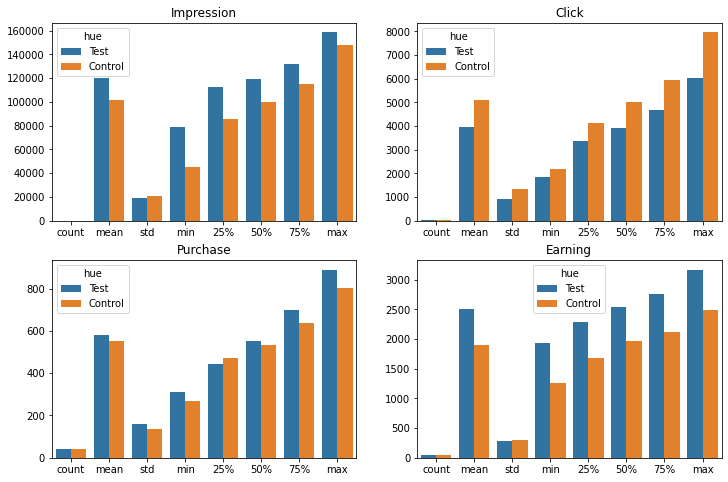

In [6]:
plt.rcParams["figure.figsize"] = (12,8)

for x,y in zip(total_describe.columns,range(1,5)):
    plt.subplot(2,2,y)
    plt.title(x)
    sns.barplot(x=describe_index,y=total_describe[x].values,data=total_describe,hue='hue')
    
plt.show()

Yeni özellikle birlikte görüntülenme, satın alma ve kazanç sayıları artmışken tıklanma sayısının azaldığı gözlemlenebilir.

In [7]:
total_group = pd.concat([test_group,control_group]).reset_index()
total_group

,index,Impression,Click,Purchase,Earning
0,0,120103.50380,3216.54796,702.16035,1939.61124
1,1,134775.94336,3635.08242,834.05429,2929.40582
2,2,107806.62079,3057.14356,422.93426,2526.24488
3,3,116445.27553,4650.47391,429.03353,2281.42857
4,4,145082.51684,5201.38772,749.86044,2781.69752
...,...,...,...,...,...
75,35,132064.21900,3747.15754,551.07241,2256.97559
76,36,86409.94180,4608.25621,345.04603,1781.35769
77,37,123678.93423,3649.07379,476.16813,2187.72122
78,38,101997.49410,4736.35337,474.61354,2254.56383


# Hipotezi tanımlama

In [8]:
# HO: M1 = M2 -> İki grup arasında istatistiksel olarak anlamlı farklılık yoktur
# H1: M1 != M2 -> ... vardır.

print(f'Test Group Earning Mean: {test_group.Earning.mean()},\nControl Group Earning Mean: {control_group.Earning.mean()}')

Test Group Earning Mean: 2514.8907326506173,
Control Group Earning Mean: 1908.568299802749


Test ve Kontrol Gruplarının kazançları arasında fark olduğunu rahatlıkla söyleyebiliriz. Ama bu farkın şans eseri mi olduğunu yoksa gerçekten bir anlamı mı olduğunu öğrenmemiz gerekiyor.

# Varsayımlar

In [9]:
# normallik varsayımı 
# verimizin normal dağılıma sahip olduğuna dair bir varsayımda bulunalım

test_stat, pvalue = shapiro(test_group.Purchase)
print(f'Test stat= {test_stat}, pvalue {pvalue}')
print(pvalue < 0.05)

test_stat, pvalue = shapiro(control_group.Purchase)
print(f'Test stat= {test_stat}, pvalue {pvalue}')
print(pvalue < 0.05)

Test stat= 0.9589452147483826, pvalue 0.15413185954093933
False
Test stat= 0.9772694110870361, pvalue 0.5891125202178955
False


p değeri 0,05'ten büyük olduğundan hipotezimizi reddedemeyiz. Her iki veri de normal dağılıma sahiptir.

In [10]:
# varyans homojenliği varsayımı
# verilerimizin varyans homojenleğine sahip olduğu varsayımında bulunalım

test_stat, pvalue = levene(test_group.Purchase,
                          control_group.Purchase)

print(f'Test stat= {test_stat}, pvalue {pvalue}')
print(pvalue < 0.05)

Test stat= 2.6392694728747363, pvalue 0.10828588271874791
False


p değeri 0,05'ten büyük olduğundan hipotezimizi reddedemeyiz. Veriler varyans homojenliğine sahiptir.

# AB Testi

### Yaptığımız testler iki varsayımımızı da doğruladı.
### Bu durumda AB Testimizi t-test ile gerçekleştiriyoruz

In [11]:
test_stat, pvalue = ttest_ind(test_group.Purchase,
                          control_group.Purchase)

print(f'Test stat= {test_stat}, pvalue {pvalue}')
print(pvalue < 0.05)

Test stat= 0.9415584300312964, pvalue 0.34932579202108416
False


p değeri 0,05'ten düşük değilse hipotezimizi reddedemeyiz. Bu, iki grubun satın alımları arasında anlamlı bir fark olmadığı anlamına gelir. Böylece test ettiğimiz yeni özelliğin satışları GERÇEKTEN iyi bir yönde etkilemediğini söyleyebiliriz. Elde ettiğimiz sonuçlar doğrultusunda test ettiğimiz özelliğin hayata geçirilmesine şuanlık ihtiyaç yoktur.